# Project 3 Web APIs & Classification

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup  
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

%matplotlib inline
sns.set(font_scale=1.5)

## EDA

In [4]:
#load the CSV file
df = pd.read_csv('../data/game_clean.csv')

#### 1. Text Feature Cleaning for Visualizations

While ploting the Wordcloud and EDA, I noticed that there are many HTML code artifacts, stopwords, and punctuations which contain the unneccessary informations. Hence I added this step to remove them. Also for the words eg "lauched","lauching", I want to return them to the same root form "launch". Stemming and Lemmatization both generate the root form of the inflected words. but Stemming follows an algorithm with steps to perform on the words which makes it faster but its results are far from prefect which can cause issues like overstemming and understemming. so I am going to use Lemmatization as lemma is an actual language word.

In [5]:
#define a funtion to clean the text feature
def clean_text(feature):
    #1, remover HTML Code artifacts
    clean_text = BeautifulSoup(feature).get_text()
    #2, remove punctuations, single letters, "http", ect unneccessary words 
    letters_only = re.sub("\W", " ", clean_text)
    remove_http = letters_only.replace("http", "")
    remove_www = remove_http.replace("www", "")
    remove_single_letter = re.sub(" \w ", " ", remove_www)
    remove_single_number = re.sub(" \w ", " ", remove_single_letter)
    remove_reddit=remove_single_number.replace("reddit","")
    remove_com=re.sub(" com "," ", remove_reddit)
     # 3. Convert to lower case, split into individual words.
    words = remove_com.lower().split()
    
    # 4.  convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
   
    # 6. return base/dictionary form of a word
    lemmatizer = WordNetLemmatizer()
    meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
 
    return(" ".join(meaningful_words_lem))

In [6]:
#clean the text feature and put them in the seperte list
list_ps=[]
for post in df["feature"][df["subreddit"]=="PS5"]:
         list_ps.append(clean_text(post))
list_xbox=[]
for post in df["feature"][df["subreddit"]=="XboxSeriesX"]:
         list_xbox.append(clean_text(post))

In [7]:
list_ps

['transferring ps4 data ps5 work forgive answered trouble finding anything thinking going ahead selling ps4 pro like know able transfer everything ps5 thanks',
 'important question buy digital game ps5',
 'ps4 game run better ps5 even without performance upgrade patch sorry basic question wondering game like rdr2 tlou2 automatically run better better graphic higher performance frame rate etc ps5 played ps4 need actual upgrade improved ps5',
 'playstation home single greatest thing ps3 potential could fully realised ps5 also would perfect playstation vr would buy ps5 service return',
 'worth worth spend money ps5 1080p 144hz display would waste potential idk tell think buy forgot mention first console dont game played many p game could buy used ps4 cheap buy',
 'sony say cinematic gameplay footage captured ps5 system mean using built recorder ps5 using device capture gameplay ps5',
 'evolution five night freddy fnaf 2014 2020',
 'must game around launch thinking demon soul mile morale a

#### TfidfVectorizer VS CountVectorizer 

Both methods for converting text data into vectors as model can process only numerical data. CountVectorizer only counts the number of times a word appears in the document.TfidfVectorizer will consider the overall document weightage of a word by measuring how often they appear in the documents. 

Using Countvectorizer will result in biasing in favor of most frequent words and ignoring rare words which could help in modeling our data more efficiently. Hence, to overcome this, I use TfidfVectorizer.

In [8]:
# Instantiate the "CountVectorizer"
vectorizer1 = TfidfVectorizer()
vectorizer2 = TfidfVectorizer() 
#fits the model and learns the vocabulary and transforms the data
xbox_features = vectorizer1.fit_transform(list_xbox)
ps_features = vectorizer2.fit_transform(list_ps)

In [10]:
xbox_features

<1073x4513 sparse matrix of type '<class 'numpy.float64'>'
	with 29936 stored elements in Compressed Sparse Row format>

In [6]:
#convert to dataframe
xbox_feature=pd.DataFrame(xbox_features.todense(),columns=vectorizer1.get_feature_names())

In [7]:
#convert to dataframe
ps_feature=pd.DataFrame(ps_features.todense(),columns=vectorizer2.get_feature_names())

In [8]:
#display the statistic summary
xbox_feature.sum().describe()

count    4513.000000
mean        1.031622
std         2.485656
min         0.052416
25%         0.175920
50%         0.368339
75%         0.912109
max        63.787077
dtype: float64

In [9]:
#display the statistic summary
ps_feature.sum().describe()

count    5480.000000
mean        0.889713
std         2.104027
min         0.016234
25%         0.147119
50%         0.331612
75%         0.803930
max        57.574411
dtype: float64

#### 3. Data Visualizations

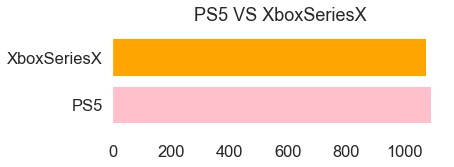

In [10]:
#plot the distribution plot for Target variable
ax=df.subreddit.value_counts().plot(kind="barh",figsize=(6,2),title="PS5 VS XboxSeriesX",width=0.8, color=['pink', 'orange'])
ax.set_facecolor('white')

To fit our model to the classification model, we need to have roughly equally-sized classes to general better performance. From the above histogram, we can see both Xboxseries and PS5 have around 1000 data. So the two-class are roughly equally-sized.

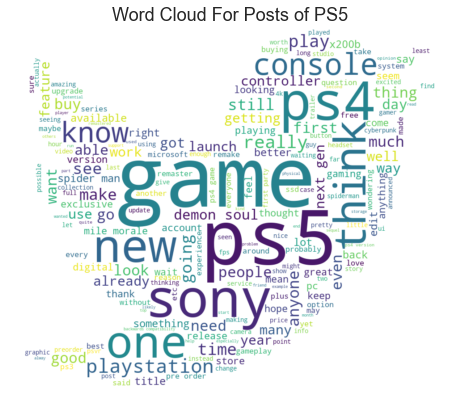

In [11]:
## Draw word cloud for post of"PS5"
text = " ".join(post for post in list_ps)
twitter_mask = np.array(Image.open("../image/twitter_mask.png"))
wordcloud = WordCloud(background_color="white",mask=twitter_mask).generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud For Posts of PS5")
plt.axis("off")
plt.show()

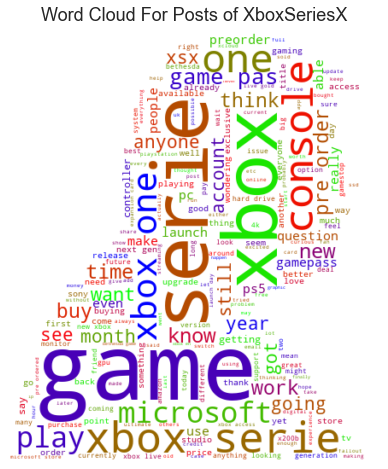

In [12]:
## Draw word cloud for post of"XboxseriesX"
text = " ".join(post for post in list_xbox)
trump_mask = np.array(Image.open("../image/trump_mask.png"))
wordcloud = WordCloud(background_color="white",mask=trump_mask,colormap='brg').generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud For Posts of XboxSeriesX")
plt.axis("off")
plt.show()

Previous generation owners seemed to be most interested in the newer version of their respective consoles: PS4 to PS5, Xbox One X to Xbox Series X

These PS exclusive games titles appeared to classify for the PS5
- Marvel's Spider-man Series
- Demon Souls Series


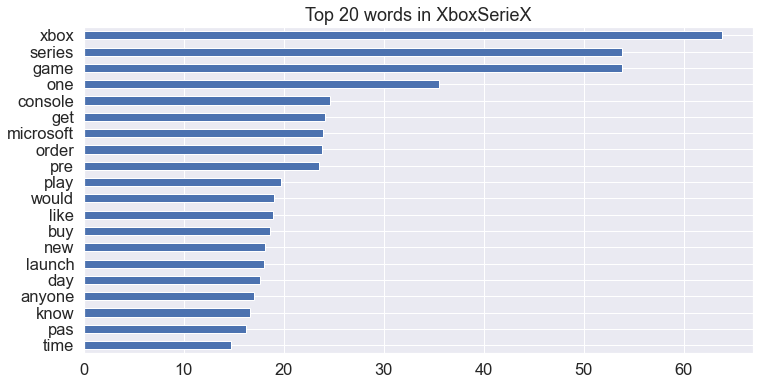

In [13]:
#plot the bar chart for top 20 words for XboxSeriesX
xbox_feature.sum().sort_values().tail(20).plot(kind="barh",figsize=(12,6),title="Top 20 words in XboxSerieX")

The most frequent words for XboxseriesX posting are Xbox, series, game ect.

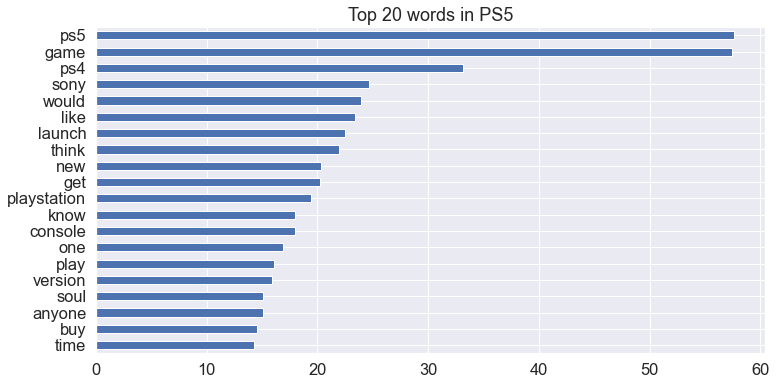

In [14]:
#plot the bar chart for top 20 words for PS5
ps_feature.sum().sort_values().tail(20).plot(kind="barh",figsize=(12,6),title="Top 20 words in PS5")

The most frequent words for PS5 posting are game, PS4, PS5 ect.

From EDA, the most important insight I draw from this part is our data set contains roughly equally-sized classes for PS5 and XboxSeries, which is very important for general better performance during the modeling. Secondly, there are many HTML code artifacts, stopwords, and punctuations that contain unnecessary information. I will remove them and return the words to their base form during the preprocessing stage. Lastly, we can see the text data in this project are very noisy and high-dimensional.  Multinomial NB will classify a document based on the counts it finds of multiple keywords. The naive assumption that predictors are independent of one another is a particularly strong constraint that yields a highly interpretable model. Complex models contain many parameters usually have lower bias but higher variance. When the predictors are not independent, Multinomial NB actually introduce the bias to the model. According to Bias and Variance trade-off,  the introduced bias may sufficiently reduce variance to perform better especially in the text classification. Hence, I will choose Multinomial NB as one of the classifiers in this project. Further, I will compare with the Logistic Regression model as I assume there is the linearity of independent variables and log odds and be little or no multicollinearity among the independent variables. The default regularization function in logistic regression will penalize the less essential words and preventing overfitting.

## Preprocessing and Modeling

In [15]:
#Convert PS5/XboxSeriesX into binary labels:
df['subreddit'] = df['subreddit'].map({'PS5': 0, 'XboxSeriesX': 1})
df.head()

,title,selftext,subreddit,num_comments,upvote,feature
0,Welcoming Bethesda to the Xbox Family,&amp;#x200B;\n\nhttps://preview.redd.it/du20aq...,1,76,0.94,Welcoming Bethesda to the Xbox Family &amp;#x2...
1,"Beginner's Guide to XSX/XSS, Game Pass, Storag...",Welcome to the Xbox family!\n\nThe next genera...,1,20,0.95,"Beginner's Guide to XSX/XSS, Game Pass, Storag..."
2,Sharing this coloured pencil fanart of Master ...,NaN,1,56,0.98,Sharing this coloured pencil fanart of Master ...
3,Tom Warren on Twitter - Microsoft will make Be...,NaN,1,208,0.96,Tom Warren on Twitter - Microsoft will make Be...
4,"Someone sent me this, I thought you might like it",NaN,1,299,0.93,"Someone sent me this, I thought you might like..."


#### Baseline accuracy

We need to calculate baseline accuracy in order to tell if our model is outperforming the null model (predicting the majority class).

In [16]:
df['subreddit'].value_counts(normalize=True)

0    0.504159
1    0.495841
Name: subreddit, dtype: float64

#### Train/Test split

In [17]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(df["feature"],
                                                    df['subreddit'],
                                                    test_size = 0.20,
                                                    random_state = 42,)

#### Text Cleaning

The web links should be removed from the text documents, but our models perform down to the same as the baseline score after removing the links. Thus, I remove the unnecessary word like "http," "com", "www" instead of remove the whole link.

In [18]:
#define a funtion to clean the text feature
def clean_text(feature):
    #1, remover HTML Code artifacts
    clean_text = BeautifulSoup(feature).get_text()
    #2, remove punctuations, single letters, "http", ect unneccessary words 
    letters_only = re.sub("\W", " ", clean_text)
    remove_http = letters_only.replace("http", "")
    remove_www = remove_http.replace("www", "")
    remove_single_letter = re.sub(" \w ", " ", remove_www)
    remove_single_number = re.sub(" \w ", " ", remove_single_letter)
    remove_reddit=remove_single_number.replace("reddit","")
    remove_com=re.sub(" com "," ", remove_reddit)
     # 3. Convert to lower case, split into individual words.
    words = remove_com.lower().split()
    
    # 4.  convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
   
    # 6. return base/dictionary form of a word
    lemmatizer = WordNetLemmatizer()
    meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
 
    return(" ".join(meaningful_words_lem))

In [19]:
#clean the test and train set data
clean_train = []
for item in X_train:
    clean_train.append(clean_text(item))
clean_test = []
for item in X_test:
    clean_test.append(clean_text(item))

In [20]:
#pipeline will consist of two stages
pipe1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [21]:
#pipeline will consist of two stages
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(),)
])

In [22]:
#search best parameters
pipe_params1 = {
    'tvec__max_features': [4000,4500,5000],
    'tvec__ngram_range': [(1,1),(1,2)],
    'tvec__max_df': [0.9,0.95],
    'tvec__min_df': [0.1,0.2],
    'nb__alpha':[0.2,0.3]
}
gs1 = GridSearchCV(pipe1, param_grid=pipe_params1, cv=3)
gs1.fit(clean_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.854419410745234


{'nb__alpha': 0.2,
 'tvec__max_df': 0.9,
 'tvec__max_features': 4000,
 'tvec__min_df': 0.1,
 'tvec__ngram_range': (1, 2)}

In [23]:
#print the MNB accuracy score for train set
gs1.score(clean_train, y_train)

0.8584633160023109

In [24]:
#print the MNB accuracy score for test set
gs1.score(clean_test, y_test)

0.8475750577367206

In [25]:
#search best parameters
pipe_params2 = {
    'tvec__max_features': [4000,4500,5000],
    'tvec__ngram_range': [(1,1),(1,2)],
    'tvec__max_df': [0.9,0.95],
    'tvec__min_df': [0.1,0.2],
    'lr__C':[0.1,0.2]
}
gs2 = GridSearchCV(pipe2, param_grid=pipe_params2, cv=3)
gs2.fit(clean_train, y_train)
print(gs2.best_score_)
gs2.best_params_

0.8509532062391681


{'lr__C': 0.2,
 'tvec__max_df': 0.9,
 'tvec__max_features': 4000,
 'tvec__min_df': 0.1,
 'tvec__ngram_range': (1, 1)}

In [26]:
#print the LR accuracy score for train set
gs2.score(clean_train, y_train)

0.8601964182553438

In [27]:
#print the LR accuracy score for test set
gs2.score(clean_test, y_test)

0.8452655889145496

After Tuning the hyperparameters, both models achieve their best performance. The baseline accuracy of the null model is around 0.5. Both Multinomial NB and Logistic Regression models are outperforming the null model.  Multinomial NB has slightly higher mean accuracy when predicting the new data. Also, Multinomial NB has a smaller mean accuracy differences between the Train and Test set, which means the MNB  model can better generalized new data than Logistic regression in this project.

|      |Train score        |Test  Score      |
|----- |-------------------|-----------------|
|MNB   |0.858              |0.848            |   
|LR    |0.860              |0.845            | 

## Evaluation

In [28]:
#predict the result by MNB
y_preds_nb = gs1.predict(clean_test)

In [29]:
#predict the result by LR
y_preds_lr = gs2.predict(clean_test)

In [30]:
pd.DataFrame(confusion_matrix(y_test, y_preds_nb),
                columns=['predict /PS5', 'predict /XboxseriesX'],
                index=['actual /PS5', 'actual /r/XboxseriesX'])

,predict /PS5,predict /XboxseriesX
actual /PS5,197,19
actual /r/XboxseriesX,47,170


In [31]:
#print the confusion matrix for Logistic regression model
pd.DataFrame(confusion_matrix(y_test, y_preds_lr),
            columns=['predict/PS5', 'predict /XboxseriesX'],
            index=['actual /PS5', 'actual /r/XboxseriesX'])

,predict/PS5,predict /XboxseriesX
actual /PS5,199,17
actual /r/XboxseriesX,50,167


In [32]:
# Examine some classification metrics for MNB model
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_nb).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8476
Misclassification rate: 0.1524
Precision: 0.8995
Recall: 0.7834
Specificity: 0.912


In [33]:
# Examine some classification metrics for LR model
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_lr).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8453
Misclassification rate: 0.1547
Precision: 0.9076
Recall: 0.7696
Specificity: 0.9213


In [34]:
#print the f1 score
f1_score(y_test,y_preds_lr,average="weighted")

0.8443892875276608

In [35]:
#print the f1 score
f1_score(y_test,y_preds_nb,average="weighted")

0.8469580452268092

The Multinomial NB model has better accuracy and lower misclassification rates in predicting new data. Recall and specificity are equally important in this project, and there is always a trade-off between Recall and specificity. We will not use metrics: precision, specificity, and Recall to compare the two models performance. Instead, we will only compare their accuracy, misclassification Rate, f1 score, and ability to generalize the new data. Hence, Multinomial NB is the winner.

|                           |MNB       |LR       |
|-------------------------- |----------|---------|
|Accuracy                   |0.8476    |0.8453   |   
|Misclassification Rate     |0.1524    |0.1547   | 
|Precision                  |0.8995    |0.9076   | 
|Recall                     |0.7834    |0.7696   | 
|Specificity                |0.912     |0.9213   |
|f1_score                   |0.8470    |0.8444   | 

#### Adjust the Threshold for Multinomial NB model to optimize the seperation

In [36]:
#adjust the Threshold
threshold = 0.4944
y_pred = (gs1.predict_proba(clean_test)[:, 1] > threshold).astype('float')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8522
Misclassification rate: 0.1478
Precision: 0.84
Recall: 0.871
Specificity: 0.8333


Besides, Both models show lower Recall but higher specificity, which means both models work much better in predicting potential PS5 users(1:XboxSeries,0:PS5) than predicting the potential XboxSeriesX users. After adjusting the Threshold to optimize the Sensitivity in MNB, the overall accuracy was increased. However, We have to sacrifice the specificity to has better prediction for XboxSeries. Also, No matter how we adjust the Threshold, the classification for XboxSeriesX will not as good as PS5 (specificity before the adjustment). I guess the reasons should be related to our data itself. The XboxseriesX posts collected in this project are slightly less than PS5; PS5 may have more unique features or PS5 exclusive games, e.g., spider man Miles Morales for gamers to discuss so that machine learning can recognize PS5 better.

As of December 2019, there are over [103 million active Playstation users](https://en.wikipedia.org/wiki/PlayStation#:~:text=The%20PlayStation%20Network%20is%20an,(as%20of%20December%202019)) and [90 million active Xbox users](https://www.vg247.com/2020/04/30/xbox-live-user-numbers-2020/#:~:text=Animal%20Crossing-,Xbox%20Live%20has%2090%20million%20monthly%20users,hundreds%20of%20thousands%20testing%20xCloud&text=Microsoft%20recently%20revealed%20Xbox%20Live,almost%2090%20million%20monthly%20players.) all over the world. The structure of the Reddit online community is complicated and difficult to reach. So it is hard to determin a suitable sample size that can represent the whole population to train the model. In this project, we will assume the sample mean for the choices between PS5 and XboxseriesX will be normally distributed. According to the [sample size statistic calculation](https://www.surveysystem.com/sscalc.htm), we need to have around 2000 samples to achieve Confidence Level:95% and confidence interval:3% to represent the whole population's choices. We will use 2000 as a sample size guideline. Our sample size is about 1000 for each class, very close to it. However, there are only 1600 samples used to train the model after the train/test split. Thus, I believed we need a larger sample size for the machine learning to improve the performance.